In [71]:
import pandas as pd
import torch
from sklearn.model_selection import GroupShuffleSplit, train_test_split 
from models import latent_annotator_clustering, utils, MLP 
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('./data/largeScale.csv')
# remove unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.drop_duplicates()

In [17]:
# df_aae = df[df["isAAE"] == True]
df_aae = df

In [18]:
df_aae_annotator = df_aae[['annId', 'annotatorAge', 'annotatorGender', 'annotatorMinority', 'annotatorRace', 'annotatorPolitics']].drop_duplicates()


ann_to_remove = df_aae_annotator[df_aae_annotator["annId"].duplicated() == True]['annId'].unique().tolist()
df_aae = df_aae[~df_aae["annId"].isin(ann_to_remove)]
df_aae_annotator = df_aae_annotator[~df_aae_annotator["annId"].isin(ann_to_remove)]

# post_counts = df_aae['postId'].value_counts()

# df_aae = df_aae[df_aae['postId'].isin(post_counts[post_counts > 1].index)]


annotator_ids = df_aae_annotator['annId'].unique().tolist()

id2annotator = {index: row for (index, row) in enumerate(annotator_ids)}
annotator2id = {row: index for (index, row) in enumerate(annotator_ids)}

# minimize the toyou and toany columns by 1
df_aae['toyou'] -= 1
df_aae['toany'] -= 1

df_aae["annId"] = df_aae["annId"].map(annotator2id)
df_aae_annotator["annId"] = df_aae_annotator["annId"].map(annotator2id)

df_aae = df_aae[['annId', 'toyou', 'toany', 'postId', 'tweet', 'ogLabelToxic' ]]

/var/folders/rx/yph03t6935g4rx_gyjbqlhk00000gn/T/ipykernel_53219/2504770886.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aae['toyou'] -= 1
/var/folders/rx/yph03t6935g4rx_gyjbqlhk00000gn/T/ipykernel_53219/2504770886.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aae['toany'] -= 1
/var/folders/rx/yph03t6935g4rx_gyjbqlhk00000gn/T/ipykernel_53219/2504770886.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [19]:
post_counts

545     6
3511    6
77      6
1642    6
3338    6
       ..
1865    2
415     2
3472    2
1842    2
3405    1
Name: postId, Length: 627, dtype: int64

# Latent Annotator Clustering model

In [6]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 0)
split = splitter.split(df_aae, groups = df_aae['postId'])
train_inds, test_inds = next(split)


train_df = df_aae.iloc[train_inds]
test_df = df_aae.iloc[test_inds]

train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [7]:
len(train_df["annId"].unique().tolist())

160

In [8]:
len(test_df["annId"].unique().tolist())


96

In [9]:
len(df["annId"].unique())

184

In [10]:
len(df)

3457

In [111]:
pivot_df = pd.pivot_table(
    train_df,
    values='toany',
    index='postId',
    columns='annId'
    )

pivot_df = pivot_df.fillna(-1)

In [112]:
pivot_df.index.name = None
pivot_df.columns.name = None

In [113]:
data = list()

# Iterate over the rows of the DataFrame
for index, row in pivot_df.iterrows():
    data.append(list())
    for a in row.index:
    # Extract the annotator and annotation values from the row
        annotator = a
        annotation = int(row[a])
        # print(annotator, annotation)
        if(annotation  != -1):
        # Append the (annotator, annotation) pair to the data list
            data[-1].append((annotator, annotation))

In [114]:
A_ls, B_ls, C_ls, elbos_ls = latent_annotator_clustering.evaluate(data, len(df_aae["toany"].unique()), len(df["annId"].unique()), 20,100, smoothing=True, logspace=True)

In [115]:
clusters = B_ls.argmax(axis=1)

In [116]:
df_aae_annotator

,annId,annotatorAge,annotatorGender,annotatorMinority,annotatorRace,annotatorPolitics
0,0,40.0,woman,{},black,-0.5
1,1,35.0,man,{},black,0.0
3,2,45.0,man,{},black,0.0
6,3,30.0,woman,{},black,-0.5
8,4,40.0,woman,black; female,black,-1.0
...,...,...,...,...,...,...
3304,170,30.0,woman,{},white,0.5
3317,171,30.0,man,None,white,-0.5
3385,172,30.0,man,{},white,-1.0
3402,173,40.0,woman,{},white,-1.0


In [117]:
df_indices = train_df['annId'].unique().tolist()  # Get the indices present in the DataFrame column
clusters = [item for i,item in enumerate(clusters) if i in df_indices] 

In [118]:
len(clusters)

164

In [119]:
df_aae_annotator_trained = df_aae_annotator[df_aae_annotator["annId"].isin(df_indices)]

In [120]:
len(df_aae_annotator_trained)

164

<Axes: xlabel='Cluster'>

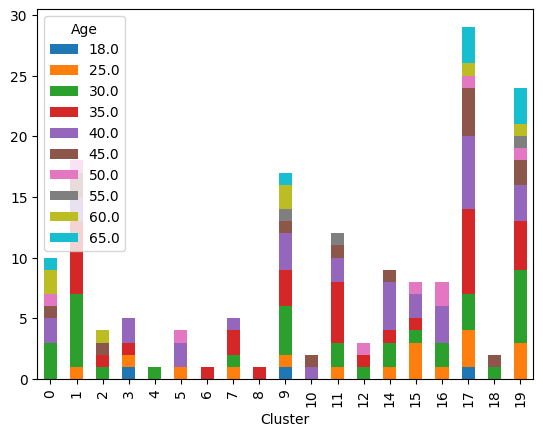

In [121]:
data = pd.DataFrame({'Cluster': clusters, 'Age': df_aae_annotator_trained.iloc[:, 1]})
grouped_data = data.groupby(['Cluster', 'Age']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Age', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Cluster'>

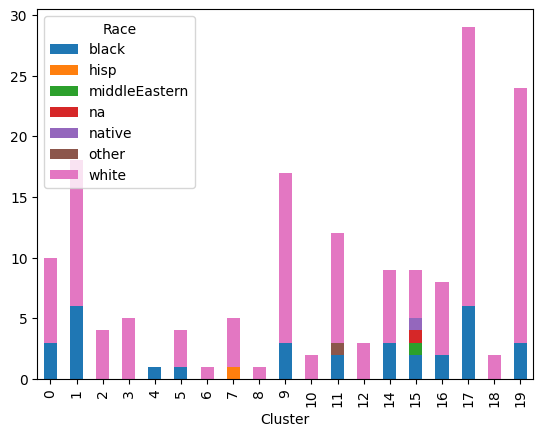

In [122]:
data = pd.DataFrame({'Cluster': clusters, "Race": df_aae_annotator_trained.iloc[:, 4]})
grouped_data = data.groupby(['Cluster', 'Race']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Race', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Cluster'>

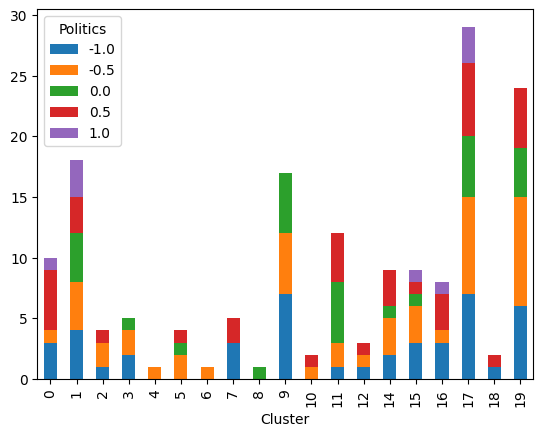

In [123]:
data = pd.DataFrame({'Cluster': clusters, 'Politics': df_aae_annotator_trained.iloc[:, 5]})
grouped_data = data.groupby(['Cluster', 'Politics']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Politics', values='Count')
pivot_table.plot(kind='bar', stacked=True)

In [124]:
# categorical_columns = [ 'gender', 'age_group']
# demographics_df['CombinedCategories'] = demographics_df[categorical_columns].apply(lambda x: ' '.join(x.astype(str)), axis=1)

to_combine = ["annotatorRace", "annotatorPolitics"]
df_aae_annotator_trained["combined"] = df_aae_annotator_trained[to_combine].apply(lambda x: ' '.join(x.astype(str)), axis=1)

/var/folders/rx/yph03t6935g4rx_gyjbqlhk00000gn/T/ipykernel_50202/1012471928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aae_annotator_trained["combined"] = df_aae_annotator_trained[to_combine].apply(lambda x: ' '.join(x.astype(str)), axis=1)


<Axes: xlabel='Cluster'>

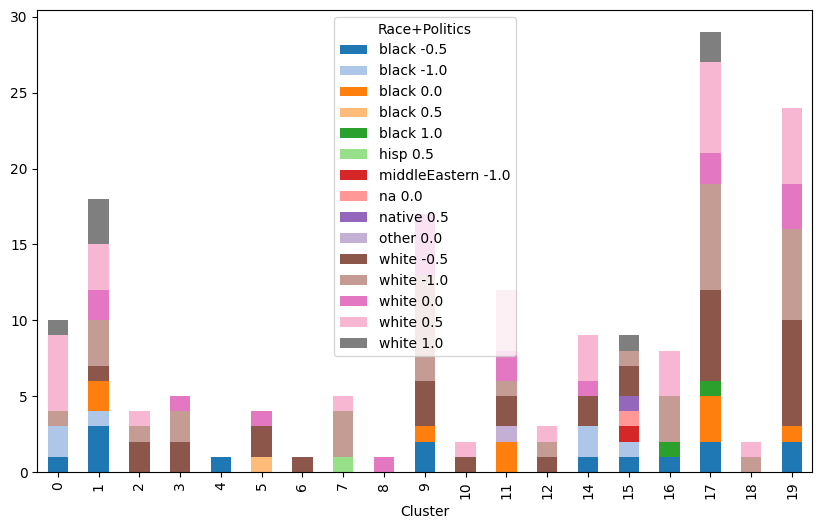

In [125]:
# Define a custom color palette with 15 colors
custom_palette = sns.color_palette('tab20', 15)

data = pd.DataFrame({'Cluster': clusters, 'Race+Politics': df_aae_annotator_trained.iloc[:, 6]})
grouped_data = data.groupby(['Cluster', 'Race+Politics']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Race+Politics', values='Count')
pivot_table.plot(kind='bar', stacked=True, color=custom_palette, figsize=(10, 6))

In [126]:
#how many times is each sentence annotated in df_aae
df_aae.groupby(['postId']).size().reset_index(name='Count').sort_values(by=['Count'], ascending=False)

,postId,Count
626,4151,6
200,1681,6
208,1697,6
207,1695,6
464,3406,6
...,...,...
310,2159,2
386,3051,2
604,3973,2
298,2132,2


# Text Embedding only

In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

pretrained_embeddings, fasttext_vocab = utils.get_fasttext()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yarakhater/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
df_aae = utils.clean_text(df_aae, 'tweet', stop_words)

/Users/yarakhater/Desktop/annotator_disagreement/models/utils.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('[\W_]', ' ')
/Users/yarakhater/Desktop/annotator_disagreement/models/utils.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('\d+', '')


In [22]:
df_aae['text_ids'] = df_aae['tweet'].apply(lambda x: x.split())
df_aae['text_ids'] = df_aae['text_ids'].apply(fasttext_vocab)

In [23]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 3)
split = splitter.split(df_aae, groups = df_aae['postId'])
train_inds, test_inds = next(split)


train_df = df_aae.iloc[train_inds]
test_df = df_aae.iloc[test_inds]

train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [24]:
len(train_df['annId'].unique())

164

In [25]:
len(test_df["annId"].unique())

95

In [26]:
len(df["annId"].unique())

184

In [33]:
classifier1 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['annId'], len(df_aae["annId"].unique()),train_df['toany'], len(train_df["toany"].unique()),mode="text")

tensor(0.0053, grad_fn=<MeanBackward0>) tensor(1.0039, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 1.6244
Epoch [2/20], Loss: 1.6230
Epoch [3/20], Loss: 1.6119
Epoch [4/20], Loss: 1.5981
Epoch [5/20], Loss: 1.5833
Epoch [6/20], Loss: 1.5684
Epoch [7/20], Loss: 1.5541
Epoch [8/20], Loss: 1.5407
Epoch [9/20], Loss: 1.5281
Epoch [10/20], Loss: 1.5164
Epoch [11/20], Loss: 1.5054
Epoch [12/20], Loss: 1.4946
Epoch [13/20], Loss: 1.4838
Epoch [14/20], Loss: 1.4746
Epoch [15/20], Loss: 1.4657
Epoch [16/20], Loss: 1.4556
Epoch [17/20], Loss: 1.4485
Epoch [18/20], Loss: 1.4405
Epoch [19/20], Loss: 1.4323
Epoch [20/20], Loss: 1.4250


In [34]:
predicted = MLP.test(test_df['text_ids'], test_df['annId'], test_df['toany'], classifier1, mode="text")

Accuracy of the model on the test set: 31.59722222222222 %


In [39]:
classifier_2 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['annId'], len(df_aae['annId'].unique()), train_df['toany'], len(train_df["toany"].unique()), mode="text_annotators")

tensor(-0.0210, grad_fn=<MeanBackward0>) tensor(1.0069, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 1.5727
Epoch [2/20], Loss: 1.4820
Epoch [3/20], Loss: 1.4368
Epoch [4/20], Loss: 1.4147
Epoch [5/20], Loss: 1.3939
Epoch [6/20], Loss: 1.3773
Epoch [7/20], Loss: 1.3609
Epoch [8/20], Loss: 1.3501
Epoch [9/20], Loss: 1.3392
Epoch [10/20], Loss: 1.3266
Epoch [11/20], Loss: 1.3081
Epoch [12/20], Loss: 1.2922
Epoch [13/20], Loss: 1.2814
Epoch [14/20], Loss: 1.2648
Epoch [15/20], Loss: 1.2515
Epoch [16/20], Loss: 1.2413
Epoch [17/20], Loss: 1.2284
Epoch [18/20], Loss: 1.2188
Epoch [19/20], Loss: 1.2095
Epoch [20/20], Loss: 1.1988


In [40]:
predicted = MLP.test(test_df['text_ids'], test_df['annId'], test_df['toany'], classifier_2, mode="text_annotators")

Accuracy of the model on the test set: 37.673611111111114 %


In [49]:
classifier_3 = MLP.train(pretrained_embeddings, train_df['text_ids'], train_df['annId'], len(df_aae['annId'].unique()), train_df['toany'], len(train_df["toany"].unique()), mode="text_groups", nb_groups=3)

tensor(0.0014, grad_fn=<MeanBackward0>) tensor(0.9946, grad_fn=<VarBackward0>)
Epoch [1/20], Loss: 1.3632
Epoch [2/20], Loss: 1.3547
Epoch [3/20], Loss: 1.3549
Epoch [4/20], Loss: 1.3503
Epoch [5/20], Loss: 1.3499
Epoch [6/20], Loss: 1.3465
Epoch [7/20], Loss: 1.3447
Epoch [8/20], Loss: 1.3419
Epoch [9/20], Loss: 1.3413
Epoch [10/20], Loss: 1.3378
Epoch [11/20], Loss: 1.3341
Epoch [12/20], Loss: 1.3319
Epoch [13/20], Loss: 1.3286
Epoch [14/20], Loss: 1.3252
Epoch [15/20], Loss: 1.3212
Epoch [16/20], Loss: 1.3181
Epoch [17/20], Loss: 1.3206
Epoch [18/20], Loss: 1.3090
Epoch [19/20], Loss: 1.3058
Epoch [20/20], Loss: 1.3000


In [50]:
predicted = MLP.test(test_df['text_ids'], test_df['annId'], test_df['toany'], classifier_3, mode="text_groups")

Accuracy of the model on the test set: 34.72222222222222 %


In [51]:
classifier_3.load_state_dict(classifier_3.state_dict())
classifier_3.eval()
group_assignment_trained = classifier_3.group_assignment

In [52]:
clusters = group_assignment_trained.max(dim=1).indices
clusters

tensor([2, 0, 1, 2, 0, 2, 1, 2, 1, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 2, 1, 1, 0, 0, 1, 1, 2, 2, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0, 1,
        2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 1, 1, 2, 1,
        1, 2, 2, 1, 0, 1, 1, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0,
        1, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 1, 0, 2, 0, 0,
        1, 0, 1, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 1, 1, 2, 2,
        1, 2, 2, 2, 0, 2, 0])

In [55]:
df_aae_annotator

,annId,annotatorAge,annotatorGender,annotatorMinority,annotatorRace,annotatorPolitics
0,0,40.0,woman,{},black,-0.5
1,1,35.0,man,{},black,0.0
3,2,45.0,man,{},black,0.0
6,3,30.0,woman,{},black,-0.5
8,4,40.0,woman,black; female,black,-1.0
...,...,...,...,...,...,...
3304,170,30.0,woman,{},white,0.5
3317,171,30.0,man,None,white,-0.5
3385,172,30.0,man,{},white,-1.0
3402,173,40.0,woman,{},white,-1.0


<Axes: xlabel='Clusters'>

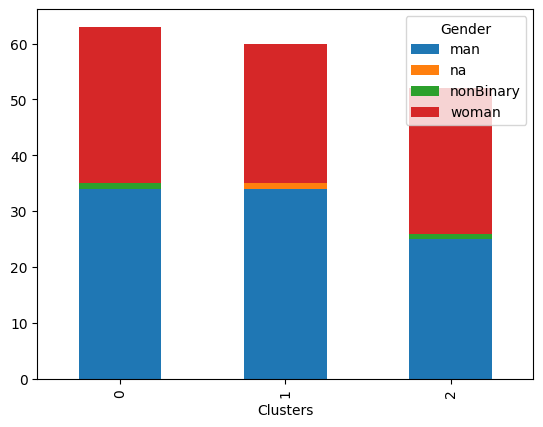

In [57]:
data = pd.DataFrame({'Clusters': clusters, 'Gender': df_aae_annotator['annotatorGender']})
grouped_data = data.groupby(['Clusters', 'Gender']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='Gender', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

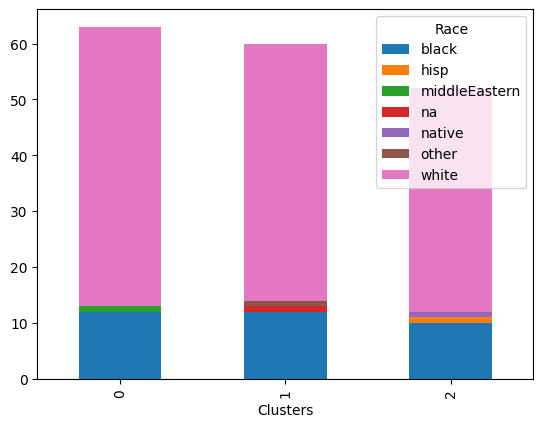

In [58]:
data = pd.DataFrame({'Clusters': clusters, 'Race': df_aae_annotator['annotatorRace']})
grouped_data = data.groupby(['Clusters', 'Race']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='Race', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Clusters'>

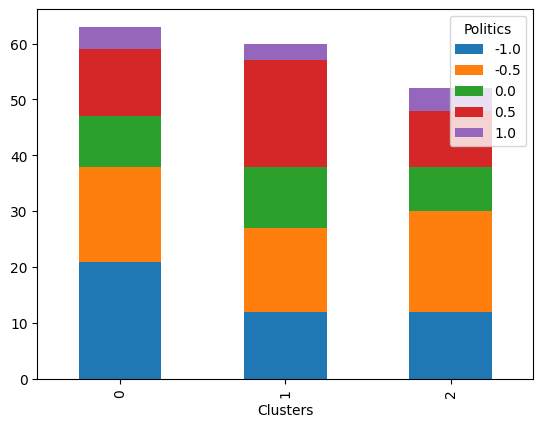

In [59]:
data = pd.DataFrame({'Clusters': clusters, 'Politics': df_aae_annotator['annotatorPolitics']})
grouped_data = data.groupby(['Clusters', 'Politics']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Clusters', columns='Politics', values='Count')
pivot_table.plot(kind='bar', stacked=True)

## annotator embeddings

In [66]:
classifier_2.load_state_dict(classifier_2.state_dict())
classifier_2.eval()
rater_embeddings_trained = classifier_2.rater_embedding.weight

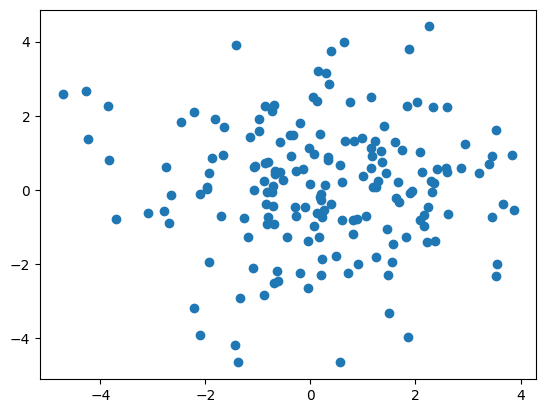

In [73]:
X = np.array(rater_embeddings_trained.detach().numpy())
# Compute the singular value decomposition of the embeddings
U, s, Vt = np.linalg.svd(X, full_matrices=False)
S = np.diag(s)
VT = Vt.T

# Project the embeddings onto the first two principal components
X = np.dot(X, VT[:, :2])

# anxiety score

colors = ['red' if score < 60 else 'blue' for score in df_aae_annotator['annotatorAge']]

# Plot the embeddings in 2D
plt.scatter(X[:, 0], X[:, 1] )
plt.show()


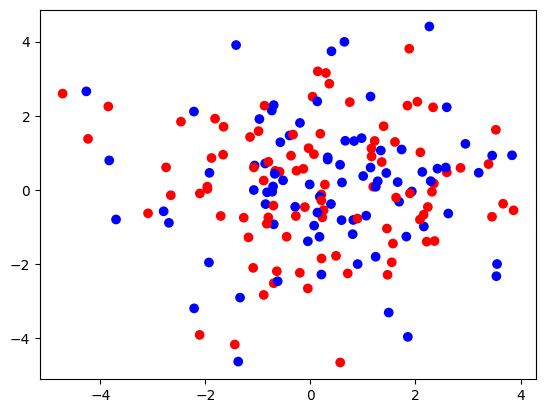

In [76]:
colors = ['red' if gender=="man"  else 'blue' for gender in df_aae_annotator["annotatorGender"]]

# Plot the embeddings in 2D
plt.scatter(X[:, 0], X[:, 1], c= colors)
plt.show()